# Sitcoms 4: Deep Learning

Now it's time for deep learning! Well, almost. We still have a bit of pre-processing to do.

This is the fourth of four notebooks completed on Sitcom Pilot Script Data. In this notebook, I will model the sitcom pilot data using deep learning techniques specific to Natural Language Processing. For those of you just joining us, this is the data that we obtained and cleaned in [Notebook 1 - Obtain/Clean](1_sitcoms_clean.ipynb), explored in [Notebook 2 - EDA](2_sitcoms_EDA.ipynb) and ran classifiers on in [Notebook 3 - Classification](3_sitcoms_classification.ipynb). 

# Table of Contents


  * 1. [Import Libraries](#import)
      * 1.1 [Open and Read Data](#open)
  * 2. [Deep Learning with Word Embeddings](#deep)  
      * 2.1. [Preprocessing for Keras](#prep)  
      * 2.2. [Build Our Neural Network](#build)  
      * 2.3. [Compile and Fit Data](#stop)  
      * 2.4  [Model Evaluation](#eval1)  
  * 3. [K-Folds Cross Evaluation](#cross)  
      * 3.1. [Define Function for Cross Eval](#define)  
      * 3.2. [Re-Evaluation](#reeval)  
      * 3.3. [Classifiers](#class)   
  * 4. [Word Embeddings with GloVe](#glove)  
      * 4.1. [Create Total Vocabulary](#vocab)  
      * 4.2. [Create Embedding Matrix](#matrix) 
      * 4.1. [Building Model 2](#build2)  
      * 4.2. [Performance of Model 2](#performance2)
  * 5. [Conclusion](#conclusion)  
      * 5.1. [Future Work](#future)  

<a id='import'></a>

# 1. Import Libraries

In [1]:
#dataframes
import pandas as pd

#math
import numpy as np
from numpy import zeros
np.random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#nltk
import nltk
from nltk import word_tokenize

#keras sequential models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

#evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

#load deep learning modules
from keras.layers import Input, Dense, LSTM, Embedding #LSTM and embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

#keras visualizations
import keras
from keras.utils import plot_model

#data preparation
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence #preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


<a id='open'></a>

### 1.1. Open and Read Data

In [2]:
data_text = pd.read_csv('scripts.csv') #open and read clean script df
df_clean = pd.read_csv('cleandata.csv') #open and read pre-processed df

<a id='deep'></a>

# 2. Deep Learning with Word Embeddings

Let's try generating our own word embedding vectors by utilizing an embedding layer inside of a deep neural network. 

<a id='prep'></a>

### 2.1. Preprocessing for Keras

Let's start by taking care of our target variable

In [3]:
target = data_text['label'] #first designate our target variable

In [4]:
y = pd.get_dummies(target).values #label encoding our target

In [5]:
y.shape #check our work

(28483, 2)

The bulk of our preprocessing will be completed using Keras functions from the Keras preprocessing library, so that our data will be optimized for our Keras CNN. The first thing we will do is tokenize the data using Keras' specific text Tokenizer. Then we wil convert our tokenized data into sequences and then pad those sequences so that they are all the same length.

In [6]:
tokenizer = text.Tokenizer(num_words=20000) #limit words in vocab to 20000
tokenizer.fit_on_texts(list(data_text.script)) #fit tokenizer
list_tokenized_scripts = tokenizer.texts_to_sequences(data_text.script) #convert to sequences
X_t = sequence.pad_sequences(list_tokenized_scripts, maxlen=100) #pad sequences

Next comes our handy dandy test-train split. Keras works best with a validation set, but we can designate that when we fit our model a little bit later.

In [7]:
#splitting our test set from our train set
X_train, X_test, y_train, y_test  = train_test_split(
    X_t, 
    y,
    train_size=0.8, 
    random_state=0)

<a id='build'></a>

### 2.2. Build Our Neural Network 

Our first layer is our input layer. After that, we begin on our embedding layer, which is where we define how large our word vectors should be (embedding size = 128, which is the first thing we specified). We will also take this time to specify the size of the embedding space itself (which works most successfully when it mirrors the size of our vocabulary, which we set to 20,000 during tokenization above). 

After leaving our embedding layer, our data's journey continues into an LSTM (Long Short Term Memory) layer, followed by a Pooling layer, a Dense layer and then an output layer. To reduce overfitting on our data, we have added a few Dropout layers along the way.

Our output layer is a dense layer with only two neurons, to correspond to the class binary (success and failure) in our labels. To retrieve a vector of predictions, we have set the activation function to 'softmax'. 

In [8]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000, embedding_size)(input_) #20000 because thats how many words we kept in our vocab
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are only 2 different possible classes, so we use 2 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


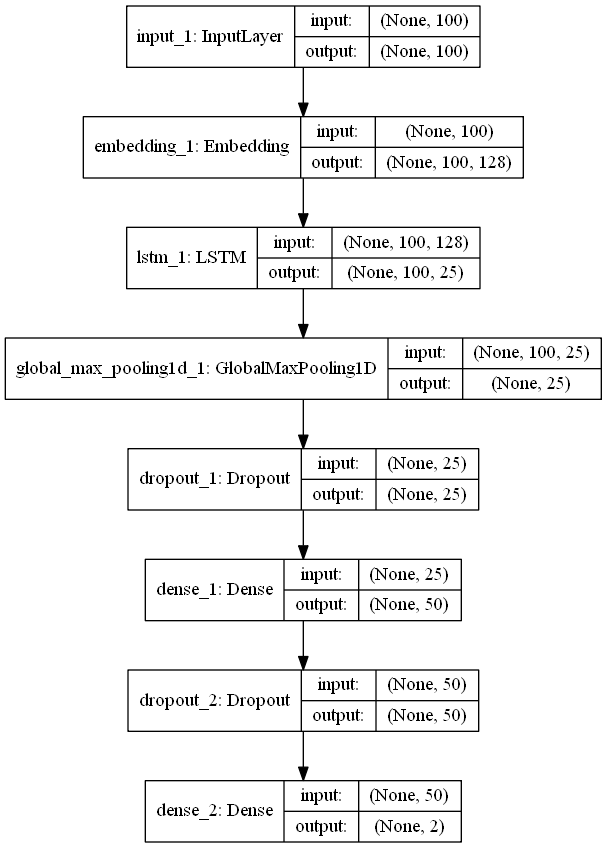

In [9]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True) #visualize overview of model

<a id='compile'></a>

### 2.3. Compile and Fit Data

We are now ready to compile our model and choose a loss function as well as an optimizer. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function, which works well with probabilities. This loss function measures the "distance" between probability distributions. The Adam optimization algorithm is an extension to stochastic gradient descent that has recently become fairly popular for natural language processing projects.

In [10]:
#compile the model
model.compile(optimizer='adam',  
              loss='binary_crossentropy',
              metrics=['accuracy'])

And finally, it's time to fit our model to our data! We will set epochs to 50 for the sake of time. This is also where we will take time to implement our validation set split that we mentioned before.

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_split=0.1) #fit the model

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 20507 samples, validate on 2279 samples
Epoch 1/50
20507/20507 [==============================] - 19s 942us/step - loss: 0.6924 - acc: 0.5204 - val_loss: 0.6912 - val_acc: 0.5362
Epoch 2/50
20507/20507 [==============================] - 20s 956us/step - loss: 0.6906 - acc: 0.5223 - val_loss: 0.6886 - val_acc: 0.5362
Epoch 3/50
20507/20507 [==============================] - 20s 958us/step - loss: 0.6814 - acc: 0.5673 - val_loss: 0.6769 - val_acc: 0.5748
Epoch 4/50
20507/20507 [==============================] - 21s 1ms/step - loss: 0.6361 - acc: 0.6439 - val_loss: 0.6599 - val_acc: 0.5893
Epoch 5/50
20507/20507 [==============================] - 21s 1ms/step - loss: 0.5691 - acc: 0.6963 - val_loss: 0.6551 - val_acc: 0.6134
Epoch 6/50
20507/20507 [==============================] - 21s 1ms/step - loss: 0.5086 - acc: 0.7271 - val_loss: 0.6837 - val_acc: 0.61

<a id='eval1'></a>

### 2.4. Model Evaluation

Let's check out the performance of our model.

In [12]:
score = model.evaluate(X_test, y_test, verbose=0) #generate score

In [13]:
#print scores
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6653948310741065
Test accuracy: 0.6097946287519748


61% is not a great accuracy score for our test data, but if we peak at the output for our model above, it looks like we got our accuracy level up to roughly 81% on the training set! Let's see what a visualization of the performance can show us.

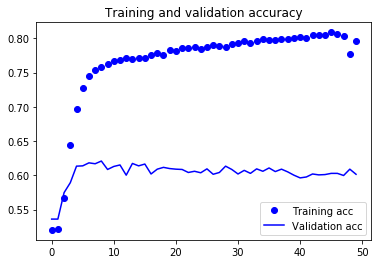

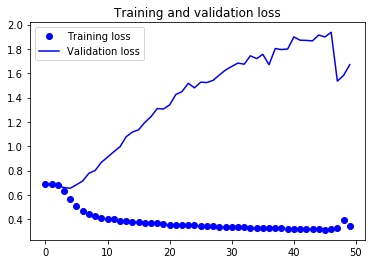

In [14]:
#generate accuracy scores for train and val set
acc = history.history['acc']
val_acc = history.history['val_acc']

#generate loss scores for train and val set
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
#plot accuracy score data
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#plot loss function data
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The difference in performance on our training set and validation set is gargantuan. In another project, this could be indicative of a massive over-fitting issue, but I am inclined to say that the difference in performance in these sets is largely due to the small size of the data. 

Because one of our largest issues seems to be our lack of data, we are going to try validating our model with k_folds cross validation, which is a resampling procedure used to evaluate machine learning models on a limited data sample.

<a id='cross'></a>

## 3. K- Folds Cross Validation

To account for the small size of our dataset, we can implement K-Folds Cross Validation instead of using a validation set. This will save us a bit of data and hopefully improve our scores. Let's re-split our data and then re-run the initial model that we created.

In [15]:
#split on X_t, which we just pre-processed above
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=123)  
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) #check shapes

(25634, 100) (2849, 100) (25634, 2) (2849, 2)


<a id='define'></a>

### 3.1. Defining a K-Folds Function

Our next step is to define a function to evaluate a model object using K-folds cross validation.

In [16]:
#defining a function to evaluate a model object using K folds cross validation.
def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=10):
    colors = sns.color_palette("Set2")

    validation_scores = [] 
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        row = i//5
        col = i%5
        X_train, X_val = features_train[train_index], features_train[test_index]
        y_train, y_val = labels_train[train_index], labels_train[test_index]
 
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=512,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score[1])
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    mean_val = print('Mean Validation Accuracy Score:', validation_score)
    stnd_val = print('Standard Deviation of Validation Accuracy Scores:', np.std(validation_scores))
    return validation_score
    return mean_val
    return stnd_val

<a id='re-eval'></a>

### 3.2. Re-Evaluation

2563/2563 [==============================] - 2s 969us/step
Mean Validation Accuracy Score: 0.8040161411465592
Standard Deviation of Validation Accuracy Scores: 0.03452021792835522
Time Elapsed: 0:40:13.623855


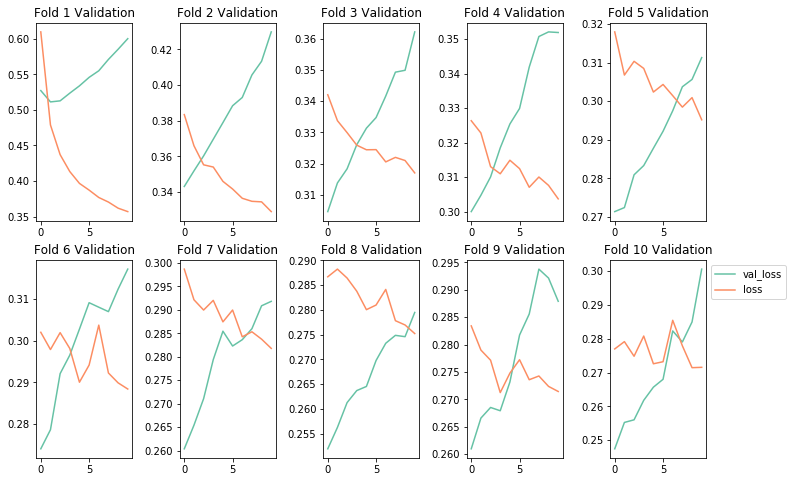

In [17]:
import time
import datetime

#keep track of how long this takes
now = datetime.datetime.now()

#fit data to k-folds
k_folds(X_train, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Using K-folds cross evaluation proved to be the necessary choice to deal with a small dataset like ours. Our loss function dropped dramatically and our mean accuracy (printed above the visuals) is a cool 80%! This accuracy score is almost 20 percent higher than our previous score of 61% and our loss function looks like it had an average score of about 35, which is also a huge improvement from the previous value of 1.91. I guess every bit of data counts! While it did take about 30 minutes to run, that's not so bad in the grand scheme of things. Now that we've built a pretty successful model, let's take a look at creating a model using another NLP word embedding technique, GloVe data!

<a id='glove'></a>

# 4. Word Embeddings with GloVe

The Keras Embedding layer can also make use of word embedding learned elsewhere.The pretrained GloVe data (retrieved from https://nlp.stanford.edu/projects/glove/) contains vectors for 6 billion words and phrases. However, I don't think these sitcoms pilot scripts are sophisticated enough to require all 6 billion of those words. We are going to generate a list of all of the unique words in our script data and only keep the vectors in the GloVe data that match up with our own total vocabulary so that we do not waste memory.

<a id='vocab'></a>

### 4.1. Create Total Vocabulary

This is similiar to what we did for generating the total vocabulary for TF-IDF data, but we will try gathering the total_vocab form our data_text dataframe instead of our df_clean dataframe.

In [18]:
data_script = data_text['script'].map(word_tokenize).values #tokenize words solely to get total_vocab variable

In [19]:
total_vocabulary = set(word for script in data_script for word in script) #add all tokens from each script into our list

In [20]:
len(total_vocabulary)
print("There are {} unique tokens in our dataset.".format(len(total_vocabulary)))

There are 12455 unique tokens in our dataset.


We skipped a few of the pre-processing techniques that we used before (such as removing common words), so it looks like our total vocabulary is a little bit longer than it was in our TF-IDF data that we used in the previous notebook. Let's move on to opening and loading GloVe. 

In [21]:
%%time

#open GloVe and read vectors
glove = {}
with open('glove.840B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

Wall time: 1min 34s


In [22]:
glove['hello'] #let's test and see if this worked

array([ 0.25233  ,  0.10176  , -0.67485  ,  0.21117  ,  0.43492  ,
        0.16542  ,  0.48261  , -0.81222  ,  0.041321 ,  0.78502  ,
       -0.077857 , -0.66324  ,  0.1464   , -0.29289  , -0.25488  ,
        0.019293 , -0.20265  ,  0.98232  ,  0.028312 , -0.081276 ,
       -0.1214   ,  0.13126  , -0.17648  ,  0.13556  , -0.16361  ,
       -0.22574  ,  0.055006 , -0.20308  ,  0.20718  ,  0.095785 ,
        0.22481  ,  0.21537  , -0.32982  , -0.12241  , -0.40031  ,
       -0.079381 , -0.19958  , -0.015083 , -0.079139 , -0.18132  ,
        0.20681  , -0.36196  , -0.30744  , -0.24422  , -0.23113  ,
        0.09798  ,  0.1463   , -0.062738 ,  0.42934  , -0.078038 ,
       -0.19627  ,  0.65093  , -0.22807  , -0.30308  , -0.12483  ,
       -0.17568  , -0.14651  ,  0.15361  , -0.29518  ,  0.15099  ,
       -0.51726  , -0.033564 , -0.23109  , -0.7833   ,  0.018029 ,
       -0.15719  ,  0.02293  ,  0.49639  ,  0.029225 ,  0.05669  ,
        0.14616  , -0.19195  ,  0.16244  ,  0.23898  ,  0.3643

Looks good to me!

<a id='matrix'></a>

### 4.2. Prepare Embedding Matrix

We now need to define a a few variables to be able to accurately use our GloVe data in our Keras sequential model.

In [23]:
#we are going to retokenize our scripts one more time so that we can make use of keras tokenizer again
#keras tokenizer will be important when creating the embedding matrix for our data a little bit later
t = Tokenizer() 
corpus = data_text.script #define script variable
t.fit_on_texts(corpus) 

#we need the length of the longest sentence to properly define the input layer in our keras model
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [24]:
vocab_length = len(t.word_index) + 1 #setting vocab_length, add 1 for place to store words with no word embeddings

In [25]:
#create embedding matrix that contains the words in our corpus 
#as well as their corresponding values from GloVe embeddings
#making use of keras tokenizer.word_index function
embedding_matrix = zeros((vocab_length, 300))
for word, index in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Before we build our model, we have to preprocess the data again to change maxlen to the length of our longest sentence during our padding step. Let's re-preprocess this data and then run our test/train split again.

In [26]:
tokenizer = text.Tokenizer(num_words=20000) #limit words in vocab to 20000
tokenizer.fit_on_texts(list(data_text.script)) #fit tokenizer
list_tokenized_scripts = tokenizer.texts_to_sequences(data_text.script) #convert to sequences
X_t = sequence.pad_sequences(list_tokenized_scripts, maxlen=length_long_sentence) #pad sequences

In [27]:
#splitting our test set from our train set one last time...
#X_t and y are still defined from our last model
X_train, X_test, y_train, y_test  = train_test_split(
    X_t, 
    y,
    train_size=0.8, 
    random_state=0)

<a id='build2'></a>

### 4.3. Building Model 2

Next up, it's time to build our model! We will not include an LSTM in this model, we will just focus on our embedding layer.

In [28]:
#round 2
input_ = Input(shape=(length_long_sentence,))
x = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)(input_)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are only 2 different possible classes, so we use 2 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model2 = Model(inputs=input_, outputs=x)

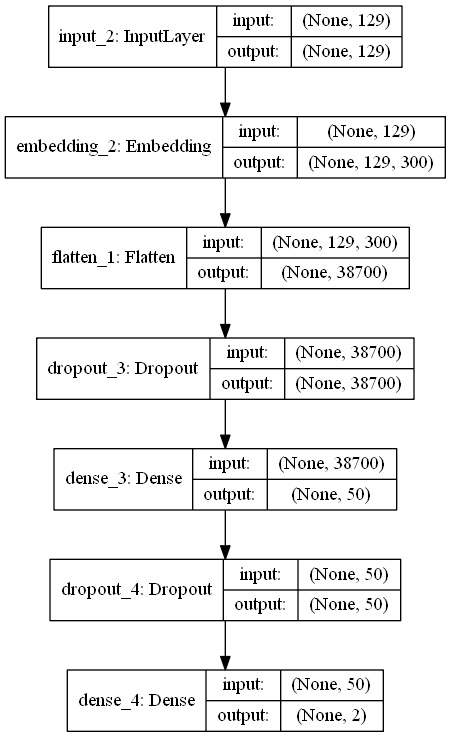

In [29]:
#visualize model summary
keras.utils.plot_model(model2, 'multi_input_and_output_model.png', show_shapes=True)

In [30]:
# compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

<a id='performance2'></a>

### 4.4. Performance of Model 2

For the sake of time, we will not use K-Folds Cross-Validation, we will just continue with using a test-train-validation method of evaluating the performance of model 2.

In [31]:
history = model2.fit(X_train, y_train, epochs=50, batch_size=512, validation_split=0.1) #fit the model

Train on 20507 samples, validate on 2279 samples
Epoch 1/50
20507/20507 [==============================] - 19s 934us/step - loss: 0.6959 - acc: 0.5211 - val_loss: 0.6899 - val_acc: 0.5445
Epoch 2/50
20507/20507 [==============================] - 18s 872us/step - loss: 0.6836 - acc: 0.5475 - val_loss: 0.6876 - val_acc: 0.5564
Epoch 3/50
20507/20507 [==============================] - 18s 863us/step - loss: 0.6744 - acc: 0.5683 - val_loss: 0.6886 - val_acc: 0.5538
Epoch 4/50
20507/20507 [==============================] - 18s 864us/step - loss: 0.6657 - acc: 0.5815 - val_loss: 0.6858 - val_acc: 0.5437
Epoch 5/50
20507/20507 [==============================] - 18s 880us/step - loss: 0.6584 - acc: 0.5909 - val_loss: 0.6905 - val_acc: 0.5533
Epoch 6/50
20507/20507 [==============================] - 18s 862us/step - loss: 0.6497 - acc: 0.5968 - val_loss: 0.6882 - val_acc: 0.5463
Epoch 7/50
20507/20507 [==============================] - 18s 863us/step - loss: 0.6460 - acc: 0.6011 - val_loss: 0.6

In [32]:
score = model2.evaluate(X_test, y_test, verbose=0) #generate scores

In [33]:
#print scores
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7653866355536757
Test accuracy: 0.5450236966824644


55% is not really a great score for binary classification, but at least we tried! Our GloVe model did not perform as well as our previous model, but I suspect it has something to do with the fact that we did not include an LSTM layer or use K-Fold cross evaluation for the sake of time.

<a id='conclusion'></a>

# 5. Conclusion

The biggest takeaway that I gathered from our models performance scores is that we need more data to accurately build a model that can determine whether or not a sitcom will fail or succeed based on a line of script from that sitcom's pilot. However, we still did learn a lot about sitcom pilot data in the process. There are many nuanced parts of a script that successful shows seem to have in common, as we did sense some level of diffence between the text data of each class. Some of these differences were hard to define or put a name to, such as how it appeared from EDA that the successful shows seemed to be more formal in their language and also put more focus on family situations rather than other social dynamics, such as those that appear at parties or in the office. 

In terms of performance, in this notebook we saw the accuracy scores on the training data get pretty high, up into the 80's. However, the best performing model overall on training data was actually a tie between two classifiers, Decision Tree and Random Forest, both on TF-IDF data and both with accuracy scores of 94%. For our test data, we had mostly lack-luster results, with the exception of our crowning jewel, which was model1 (the Keras LSTM model that we generated using our own word embeddings) when it was validated using K-Folds cross evaluation, which performed with an average accuracy score of 80% on the validation set. As we know, the remainder of the test scores were more of a letdown, with our second highest performing models being a tie between the Keras LSTM model1 (without using K-folds cross-evaluation) and Multinomial Naive Bayes on our TF-IDF data, both earning about 62% accuracy, which is not much better than the naive guessing rate. 

<a id='future'></a>

### 5.1. Future Work

In the future, I definitely think that it would be worth it to explore this project/concept again with more data. With more time, money, and resources, it would be possible to gather pilot scripts for television shows that I was unable to find on "Springfield, Springfield" (despite my emails to them requesting such :) ). This would also help to create a balanced dataset, as it was difficult to find scripts for pilots of failed sitcoms that aired more than 10 years ago.

It would also be interesting to open up this project's criteria and include a broader range of television shows, perhaps including shows that aired prior to 1989 or shows that were made by HBO or Netflix. In general, I think there is a lot of data hidden in television show scripts that would generate valuable insight about what type of content America enjoys consuming the most.

On a more technical note, there is still a lot of more work that I could do with the data at hand. For instance, parameter tuning on both the classifiers and the deep learning models could improve the test scores. I can also think of more features that would be intriguing, such as a column for locations or proper nouns in general. After adding more self-made features, it would also be worth it to try out PCA. Additionally, there are a lot of other ways to vectorize or prepare text data for modeling that could also be interesting to explore. Even in terms of EDA, there are still multiple columns that I did not fully explore, such as the actors column or most of the viewer data. 